In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.display.max_rows = 999
pd.set_option('max_colwidth', 300)
pd.options.display.float_format = '{:,.3f}'.format

In [2]:
import os 
path='C:\\Users\\sakula3\\Documents\\Python Scripts\\20190624'
os.chdir(path)
files = os.listdir()

In [3]:
## Sample file
# myheader=['Event','SubEvent','LogLevel','SarmId','TStamp','Summary']
# data = pd.read_csv('FINSAsiaObjMgr_enu_0079_82837613.log',sep='\t',skiprows=1,header=None, names=myheader,verbose=True)
# data.head()

### <h2 align='Center' style="color:blue;">Import Log Data</h2> 

In [3]:
myheader=['Event','SubEvent','LogLevel','SarmId','TStamp','Summary']
ldf=[]
for f in files:
    df = pd.read_csv(f,sep='\t',skiprows=1,header=None, names=myheader)
    ldf.append(df)
data=pd.concat(ldf)

In [5]:
# Filter by InvokeMethod
bsdata = data[(data['SubEvent'] == "InvokeMethod") & (data['Summary'].str.endswith("seconds.", na=False)) ]
# bsdata.head(5)

summary=bsdata.Summary
# summary.head(5)

# data['BS'] = summary.str.extract("'(.*?)'", expand=True)
bsdata['BS'],bsdata['Method'] = zip(*summary.str.findall("'(.*?)'"))
bsdata['Esecs'] = summary.str.extract( '(\d+.\d\d\d)',expand=True).astype('float')

C:\Users\sakula3\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\sakula3\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


###  <h2 align='Center' style="color:blue;">Business Service - Method by Average Execution Time (>2secs)</h2>

In [6]:
# Where Execution time is >= 2 Second
avgbs=bsdata[bsdata['Esecs'] >= 2].groupby(['BS','Method']).Esecs.mean()
avgbs=pd.DataFrame(avgbs)
avgbs.reset_index(level='Method', inplace=True)
avgbs.sort_values(by=['Esecs'], ascending=False, inplace=True)
avgbs

,Method,Esecs
BS,,
FINS Teller UI Navigation,RefreshCurrentApplet,8.569
Web Engine Interface,Request,5.873
EAI Siebel Adapter,Execute,5.870
PIM Client Sync Service,SiebelObjectOperations,5.802
Web Service Inbound Dispatcher,Dispatch,5.789
EAI Transport Dispatch Service,GenericDispatch,5.787
EAI Siebel Adapter,QueryPage,5.752
Synchronous Server Requests,SubmitRequest,4.694
PIM Client Metadata Service,DownloadMetadataFiles,4.214


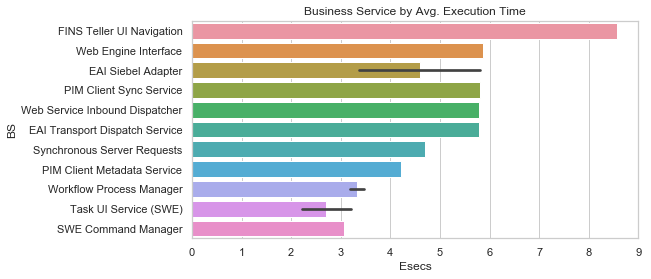

In [7]:
# Barplot for Avg. Execution Time
sns.set(style="whitegrid")
plt.figure(figsize=(8,4))
plt.title('Business Service by Avg. Execution Time')
sns.barplot(x=avgbs['Esecs'], y=avgbs.index)
plt.xlabel='Seconds'

### <h2 align='Center' style="color:blue;"> Bucket Count grouped by Business Service and Method</h2>

In [8]:

# bsdata[bsdata.Esecs > 30]


In [8]:
timesbs=bsdata.loc[:,'BS':]
timesbs=timesbs[timesbs['Esecs'] >= 2]
bins=[0,2,10000]
labels=['<2','>2']
timesbs['bins']=pd.cut(timesbs['Esecs'], bins=bins, labels=labels)
timesbs=pd.DataFrame(timesbs.groupby(['BS','Method','bins']).bins.count())
timesbs.rename(columns={'bins':'count'}, inplace=True)
timesbs.reset_index(level='bins', inplace=True)
timesbs

bins  count
BS                             Method                            
EAI Siebel Adapter             Execute                  >2     17
                               Query                    >2      2
                               QueryPage                >2    323
                               Upsert                   >2      7
EAI Transport Dispatch Service GenericDispatch          <2      3
                               GenericDispatch          >2   1725
FINS Teller UI Navigation      RefreshCurrentApplet     >2      9
PIM Client Metadata Service    DownloadMetadataFiles    >2      1
PIM Client Sync Service        SiebelObjectOperations   <2      1
                               SiebelObjectOperations   >2   1713
SWE Command Manager            #36                      >2      3
Synchronous Server Requests    SubmitRequest            >2    139
Task UI Service (SWE)          LaunchTask               >2      1
                               NavigateNext             >2      1
Web Engine Interface           Request                  <2      3
                               Request                  >2   2194
Web Service Inbound Dispatcher Dispatch                 <2      2
                               Dispatch                 >2   1725
Workflow Process Manager       RunProcess               >2     14
                               _RunSubProcess           >2      7

### <h2 align='Center' style="color:blue;">PIM Client Sync Service</h2>

In [9]:
bs1 = timesbs.loc['PIM Client Sync Service']
bs1

,bins,count
Method,,
SiebelObjectOperations,<2,1
SiebelObjectOperations,>2,1713


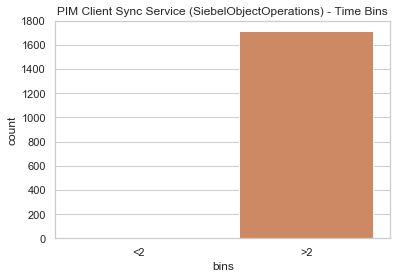

In [10]:
sns.set(style="whitegrid")
plt.title('PIM Client Sync Service (SiebelObjectOperations) - Time Bins')
sns.barplot(x=bs1['bins'], y=bs1['count'])

### <h2 align='Center' style="color:blue;">EAI Siebel Adapter</h2>

In [11]:
bs2 = timesbs.loc['EAI Siebel Adapter','QueryPage']
bs2

,,bins,count
BS,Method,,
EAI Siebel Adapter,QueryPage,>2,323


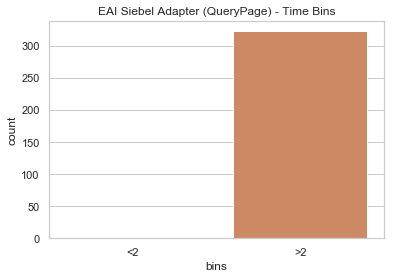

In [12]:
sns.set(style="whitegrid")
plt.title('EAI Siebel Adapter (QueryPage) - Time Bins')
sns.barplot(x=bs2['bins'], y=bs2['count'])